## 一、 将分钟数据输入HFDataView(1-5月的BHC数据)
1. 初始化不同周期的DataView
2. 读取Excel数据并合并数据
3. 处理数据格式，需要传入一个multiindex的数据，用来初始化dv。
4. 合成不同周期的数据并传入对应的DataView

## 1. 初始化不同周期的DataView

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1 = HFDataView()
dv5 = HFDataView()
dv15 = HFDataView()
dv30 = HFDataView()
dv1H = HFDataView()
dv4H = HFDataView()
dv8H = HFDataView()

## 2. 读取csv数据

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

data_excel = pd.read_csv('bch_usdt.csv').iloc[:,1:]

In [4]:
data_excel['time'] = pd.Index(map(lambda x : datetime.strptime(x, "%Y-%m-%d %H:%M:%S") , data_excel['time']))

## 3. 处理数据格式，需要传入一个multiindex的数据，用来初始化dv。
要求:trade_date、symbol为index， fields为columns. 其中,trade_date要为整数类型

In [5]:
data_excel["trade_date"] = data_excel["time"].apply(lambda x:int(x.strftime(format="%Y-%m-%d %H:%M:%S").replace("-","").replace(":","").replace(" ","")))
data_excel["symbol"] = "btc_usdt"
data_excel['usdt'] = 6.8
data_excel = data_excel.set_index(["trade_date","symbol"])
dv1.create_init_dv(data_excel) # 用来初始化dv

Initialize dataview success.


## 4. 合成不同周期的数据并传入对应的DataView
1. 用resample合并成不同周期的Bar数据
2. 传入对应的DataView

In [6]:
data_time = data_excel.set_index('time').dropna()

In [7]:
TimePeriodDict = {t:data_time.resample(t).agg({'high':'max','open':'first','close':'last','low':'min','volume':'sum','amount':'sum'}).dropna() for t in ['5Min', '15Min', "30Min", '1H', '4H', '8H']}

In [8]:
def Time_Dict(t_list=['5Min', '15Min', "30Min", '1H', '4H', '8H']):
    for t in t_list:
        TimePeriodDict[t]['time'] = TimePeriodDict[t].index
        TimePeriodDict[t]["trade_date"] = TimePeriodDict[t]['time'].apply(lambda x:int(x.strftime(format="%Y-%m-%d %H:%M:%S").replace("-","").replace(":","").replace(" ","")))
        TimePeriodDict[t]["symbol"] = "btc_usdt"
        TimePeriodDict[t]['usdt'] = 6.4
        TimePeriodDict[t] = TimePeriodDict[t].set_index(["trade_date","symbol"])
    return TimePeriodDict

In [9]:
Time_dict = Time_Dict()

In [10]:
dv5.create_init_dv(Time_dict['5Min'])
dv15.create_init_dv(Time_dict['15Min'])
dv30.create_init_dv(Time_dict['30Min'])
dv1H.create_init_dv(Time_dict['1H'])
dv4H.create_init_dv(Time_dict['4H'])
dv8H.create_init_dv(Time_dict['8H'])

Initialize dataview success.
Initialize dataview success.
Initialize dataview success.
Initialize dataview success.
Initialize dataview success.
Initialize dataview success.


## 二、计算不同周期的Alpha指标

### 计算VWAP

In [12]:
for dv in [dv1, dv5, dv15, dv30, dv1H, dv4H, dv8H]:
    dv.add_formula('vwap_c','amount/(volume*usdt)', add_data=True)

### 计算Alpha1

In [14]:
 for dv in [dv1, dv5, dv15, dv30, dv1H, dv4H, dv8H]:
        dv.add_formula('alpha1_C','Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5)',add_data=True)

## 三、 TimingDigger的使用案例

In [16]:
def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=20, LongPeriod=60, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
#     plt.savefig(chart_name)
    plt.show()

In [17]:
# dv5.get_ts('alpha1_C', date_type='datetime')

In [20]:
dv_dict = {'alpha1_dv1':dv1, 'alpha1_dv5': dv5, 'alpha1_dv15':dv15, 'alpha1_dv30':dv30, 'alpha1_dv1H':dv1H, 'alpha1_dv4H':dv4H, 'alpha1_dv8H':dv8H}
alpha1_dict = {n: dv.get_ts('alpha1_C', date_type='datetime').btc_usdt for n, dv in dv_dict.items()}

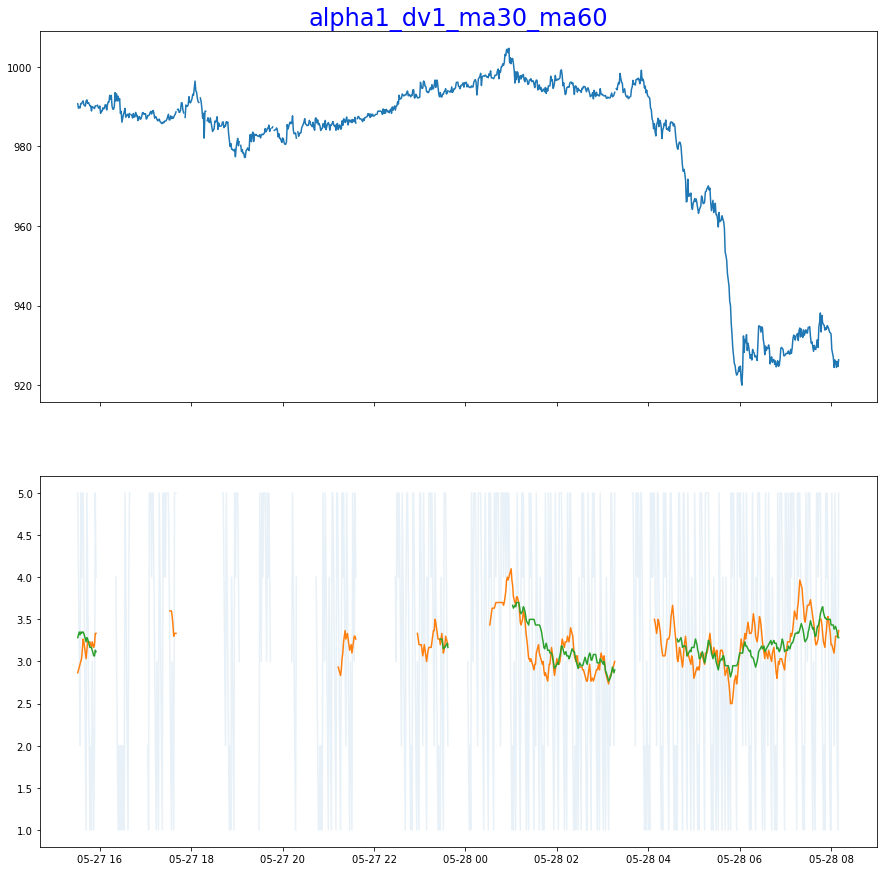

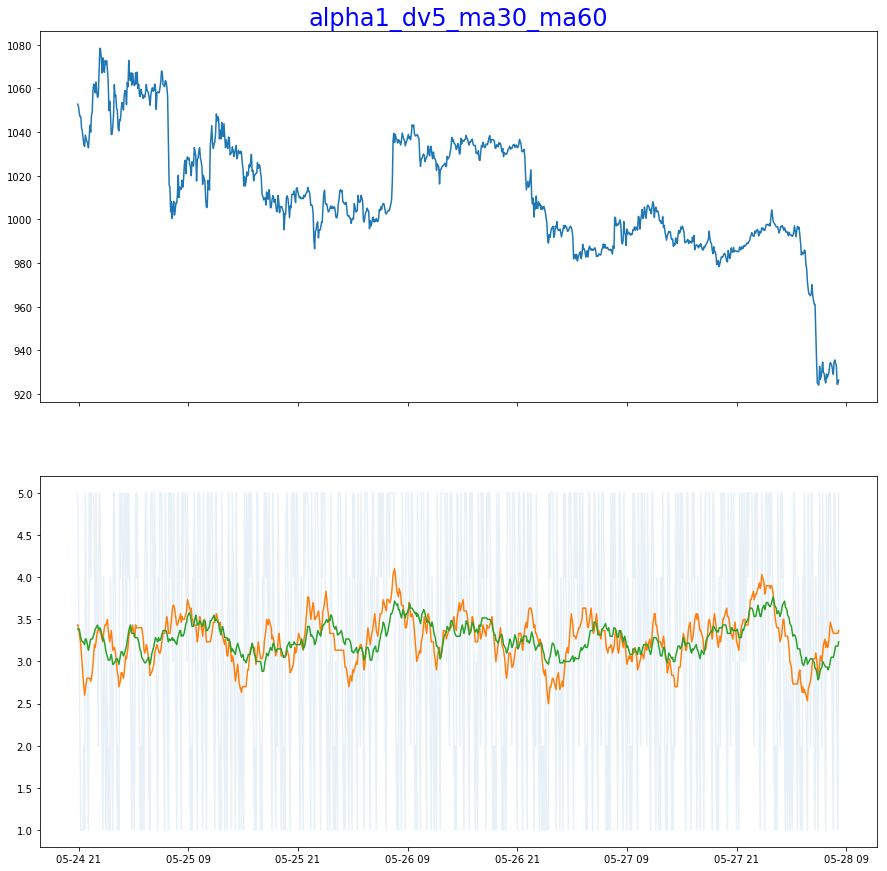

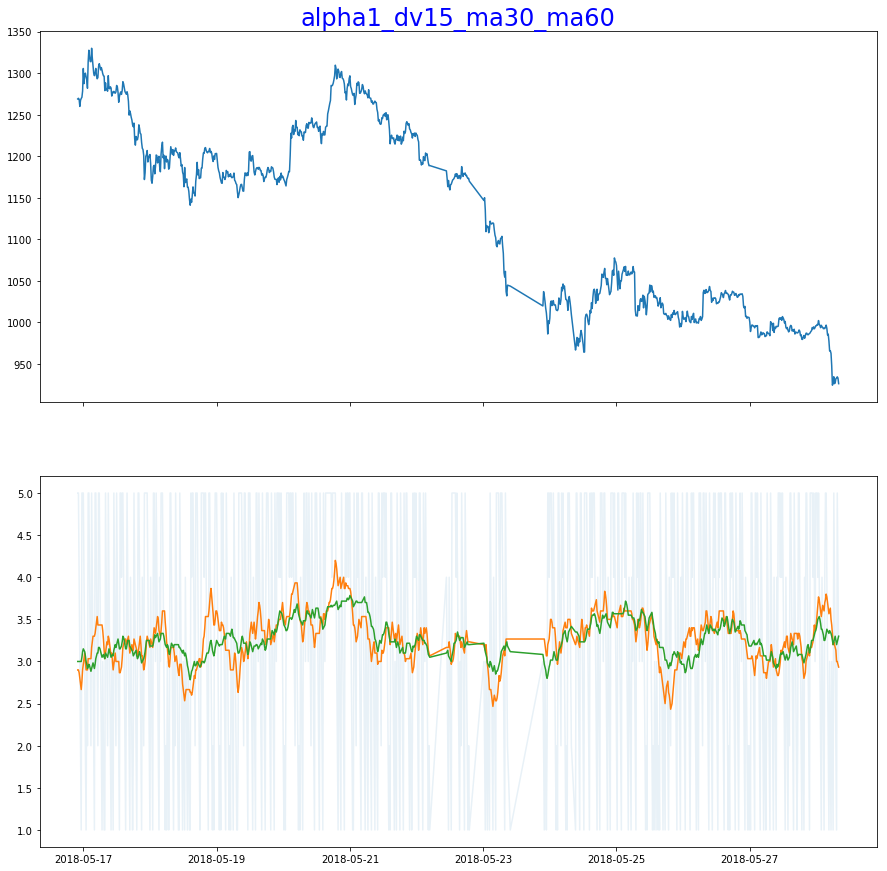

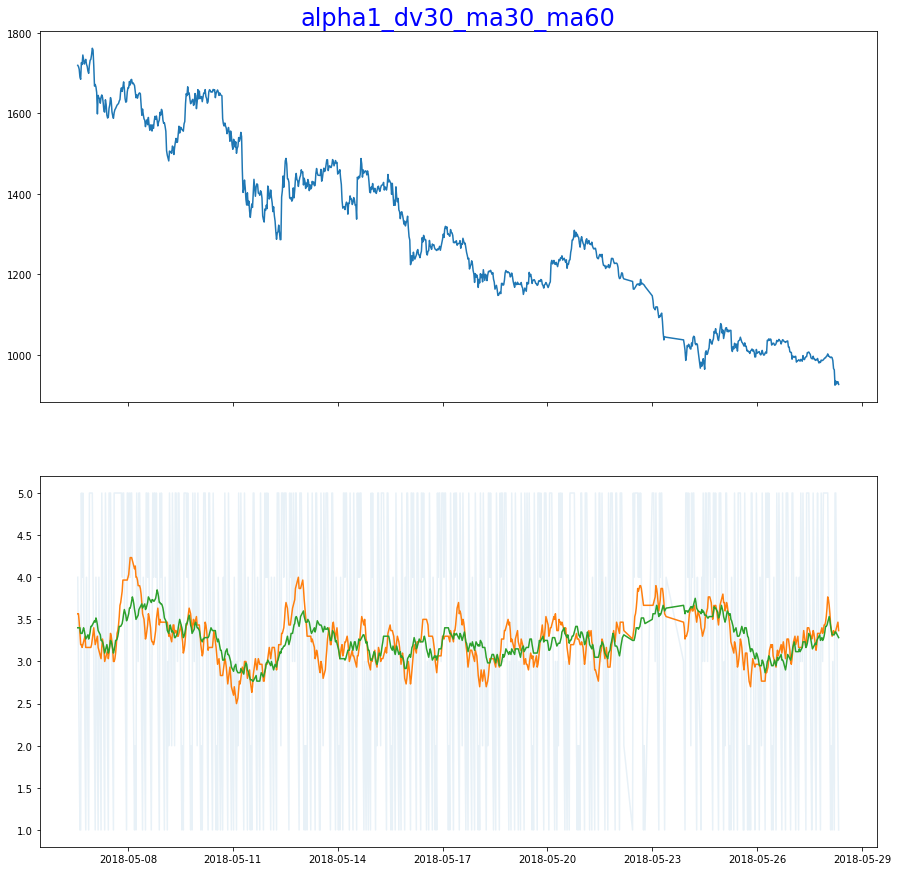

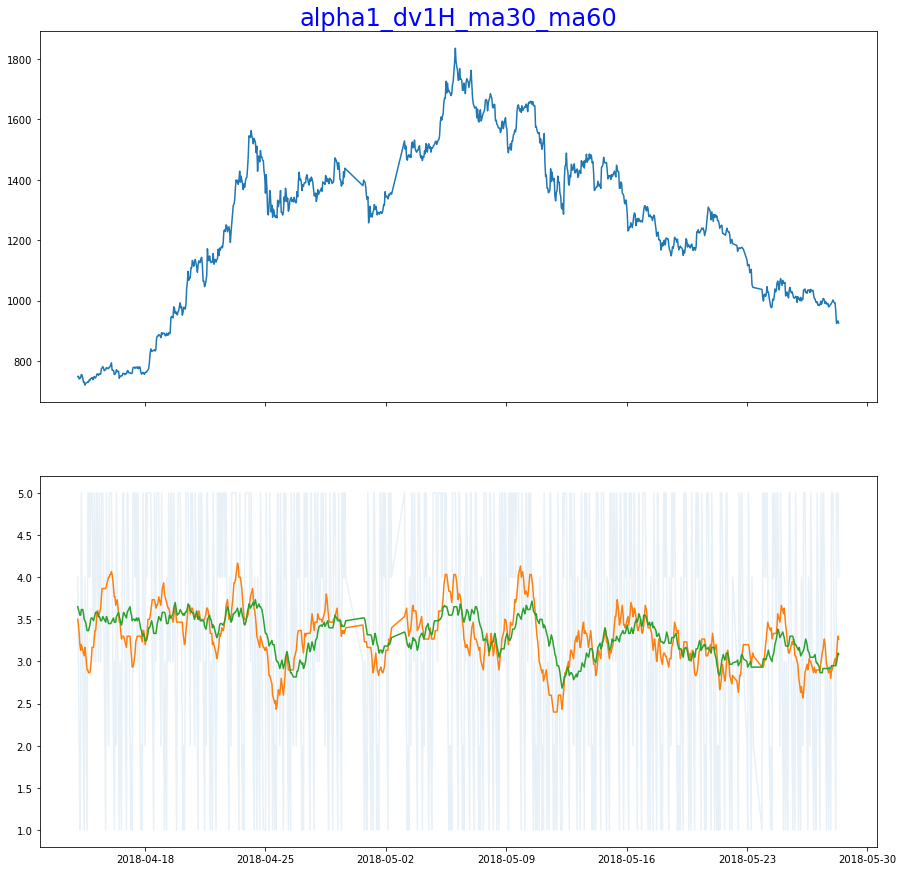

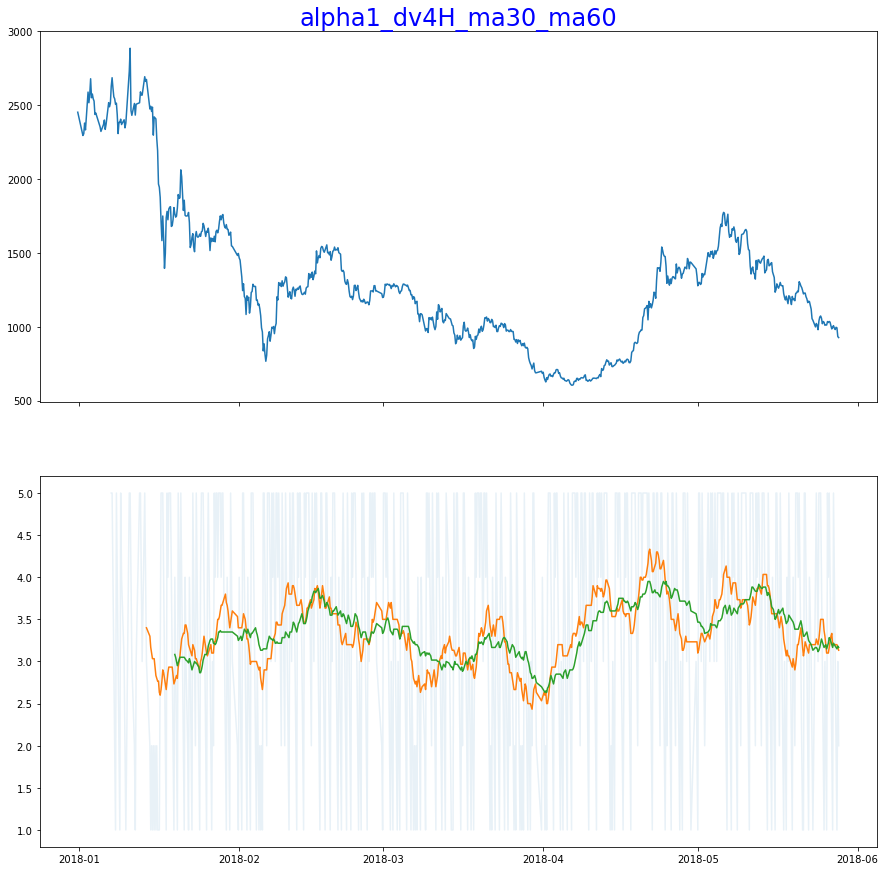

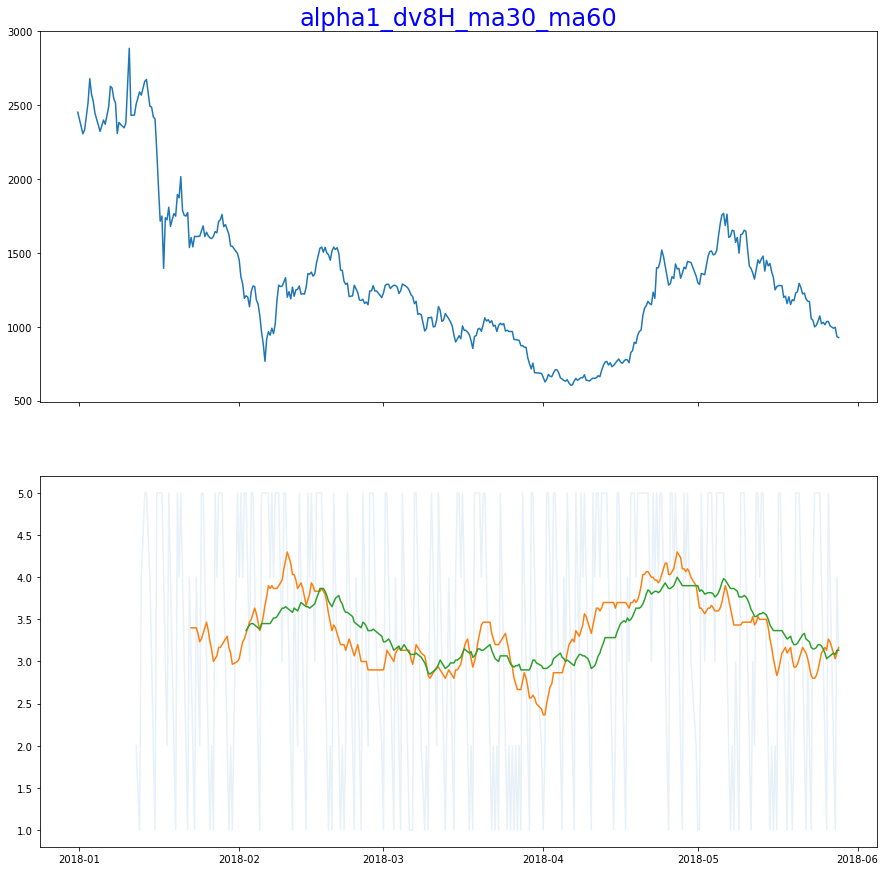

In [21]:
for name, alpha in alpha1_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha, chart_name=name+'_ma30_ma60',ShortPeriod=30, LongPeriod=60, n=-1000)

## 假设 Alpha1在8H下的MA20与MA60金叉死叉收益为0

In [22]:
# 进场信号
long = dv8H.add_formula("long","If((Ts_Mean(alpha1_C,30)>Ts_Mean(alpha1_C,60)) && (Delay(Ts_Mean(alpha1_C,30),1)<=Delay(Ts_Mean(alpha1_C,60),1)),2,0)", add_data=True)
short = dv8H.add_formula("short","If((Ts_Mean(alpha1_C,30)<Ts_Mean(alpha1_C,60)) && (Delay(Ts_Mean(alpha1_C,30),1)>=Delay(Ts_Mean(alpha1_C,60),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv8H.add_formula("closeLong","If(short==-2,1,0)", add_data=True)
close_short = dv8H.add_formula("closeShort","If(long==2,-1,0)", add_data=True)

In [23]:
dv8H.get_ts('long').stack()[dv8H.get_ts('long').stack()==2]

trade_date      symbol  
20180203000000  btc_usdt    2.0
20180205160000  btc_usdt    2.0
20180306000000  btc_usdt    2.0
20180307080000  btc_usdt    2.0
20180311080000  btc_usdt    2.0
20180316160000  btc_usdt    2.0
20180319080000  btc_usdt    2.0
20180405160000  btc_usdt    2.0
20180525160000  btc_usdt    2.0
20180528080000  btc_usdt    2.0
dtype: float64

In [25]:
from jaqs_fxdayu.research import TimingDigger

td = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha001')

def TimingSignal(mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(100, 0.05, 0.3)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%


In [26]:
td.create_event_report?

In [28]:
td.create_event_report(sig_type="long",
                       by_symbol=True)

Figure saved: E:\2018_Course\1_Research2Strategy\Alpha001/long_entry_exit_position/btc_usdt.pdf
*****-Summary-*****
Event Analysis
                         win   loss    all
t-stat              1168.323 -4.860  0.387
p-value                0.001  0.003  0.709
mean                   0.333 -0.066  0.023
std                    0.000  0.033  0.168
info_ratio          1168.323 -1.984  0.137
skewness               0.000  0.527  1.232
kurtosis              -2.000 -1.122 -0.333
pct5                   0.333 -0.104 -0.103
pct25                  0.333 -0.088 -0.078
pct50                  0.333 -0.073 -0.069
pct75                  0.334 -0.046 -0.011
pct95                  0.334 -0.015  0.333
occurance              2.000  7.000  9.000
win_ratio                NaN    NaN  0.222
win_mean/loss_mean       NaN    NaN  5.078


In [30]:
td.create_event_report(sig_type="short",
                       by_symbol=True)

Figure saved: E:\2018_Course\1_Research2Strategy\Alpha001/short_entry_exit_position/btc_usdt.pdf
*****-Summary-*****
Event Analysis
                      win   loss     all
t-stat              5.173 -6.825   2.203
p-value             0.002  0.021   0.055
mean                0.172 -0.076   0.098
std                 0.082  0.016   0.133
info_ratio          2.112 -4.826   0.734
skewness            0.161 -0.309  -0.096
kurtosis           -0.876 -1.500  -1.246
pct5                0.065 -0.095  -0.086
pct25               0.110 -0.085  -0.031
pct50               0.205 -0.073   0.110
pct75               0.209 -0.066   0.207
pct95               0.282 -0.060   0.267
occurance           7.000  3.000  10.000
win_ratio             NaN    NaN   0.700
win_mean/loss_mean    NaN    NaN   2.259


In [27]:
td.create_event_report(sig_type="long_short",
                       by_symbol=True)

Figure saved: E:\2018_Course\1_Research2Strategy\Alpha001/long_short_entry_exit_position/btc_usdt.pdf
*****-Summary-*****
Event Analysis
                      win    loss     all
t-stat              5.987  -7.021   1.702
p-value             0.000   0.000   0.106
mean                0.208  -0.069   0.062
std                 0.098   0.029   0.155
info_ratio          2.117  -2.340   0.401
skewness           -0.091   0.729   0.551
kurtosis           -1.294  -0.517  -1.204
pct5                0.070  -0.103  -0.100
pct25               0.121  -0.092  -0.073
pct50               0.208  -0.073  -0.011
pct75               0.314  -0.061   0.207
pct95               0.333  -0.017   0.333
occurance           9.000  10.000  19.000
win_ratio             NaN     NaN   0.474
win_mean/loss_mean    NaN     NaN   3.023
